# Load libraries

In [1]:
import functools

from absl import app
from absl import flags
from absl import logging

from absl import app
from absl import flags
from absl import logging

import jax
from ml_collections import config_flags

FLAGS = flags.FLAGS

import jax
import numpy as np
from typing import Any, Callable, Dict, Tuple, Sequence
from jax.nn import softplus
from jax import lax, random, numpy as jnp
from jax.scipy.special import gammaln
from flax.core import freeze, unfreeze
from flax import linen as nn
from flax import serialization
from flax.training import train_state, checkpoints
from flax import struct
import optax
import orbax.checkpoint
import ml_collections
from ml_collections import config_dict
from scipy.stats import norm, bootstrap

# Bring your packages onto the path
import sys, os
sys.path.append(os.path.abspath('..'))

import models
import train
import mycells
import utils

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as colors

from sklearn.decomposition import PCA
from scipy.ndimage.filters import gaussian_filter
import csv

# Global flag to set a specific platform, must be used at startup.
jax.config.update('jax_platform_name', 'cpu')

/tmp/ipykernel_2737984/2314655935.py:47: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Define useful functions

In [2]:
scw = []

with open('/scratch/gpfs/tdkim/findr/npx_luo/manuscript2023a/images/smooth-cool-warm-table-float-1024.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for i, rows in enumerate(reader):
        if i > 0:
            r = [float(i) for i in rows]
            scw.append(tuple(r[1:]))
            scw.append(r[0])
            
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = list(seq) + [(None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return colors.LinearSegmentedColormap('CustomMap', cdict)

c = colors.ColorConverter().to_rgb
rvb = make_colormap(scw)

def get_argmin_across_hp_grid2(ckptdir, k_cv=1, hp_indices=[]):
    vls = []
    for indx in hp_indices:
        restored_state = checkpoints.restore_checkpoint(
            ckpt_dir=ckptdir + str(indx+1), 
            target=None, 
            parallel=False
        )
        vl = []
        for ii in range(len(restored_state['losses']['train_losses'])):
            vl.append(restored_state['losses']['val_losses'][str(ii)])
        vls.append(vl)
    return hp_indices[np.argmin([min(vls[ii]) for ii, indx in enumerate(hp_indices)])]

# Color palette

In [3]:
blue = [0.229999504, 0.298998934, 0.754000139]
red = [0.706000136, 0.015991824, 0.150000072]

# Load checkpoint directories

In [4]:
datapath = '/scratch/gpfs/tdkim/findr/npx_luo/manuscript2023a/recordingsessions/2024_04_09/T176_2018_05_15.npz'
ckptdir = '/scratch/gpfs/tdkim/findr/npx_luo/manuscript2023a/fits/2024_04_09/T176_2018_05_15/config_findr_'

# Hyperparameter grid-search set

In [5]:
hp_len = 45
num_k_fold_cv = 5
dt = 0.01

k_cv_set = [1, 2, 3, 4, 5] # 5-fold cross-validation
learning_rates = 10**np.linspace(-2, -0.5, num=5)
features_set = [30, 50, 100]
net_size = [50, 100, 200]

hps = []
for i in range(len(k_cv_set)):
    for j in range(len(learning_rates)):
        for k in range(len(features_set)):
            for l in range(len(net_size)):
                hps.append(
                    (
                        k_cv_set[i], 
                        learning_rates[j], 
                        features_set[k],
                        net_size[l]
                    )
                )
hps

[(1, 0.01, 30, 50),
 (1, 0.01, 30, 100),
 (1, 0.01, 30, 200),
 (1, 0.01, 50, 50),
 (1, 0.01, 50, 100),
 (1, 0.01, 50, 200),
 (1, 0.01, 100, 50),
 (1, 0.01, 100, 100),
 (1, 0.01, 100, 200),
 (1, 0.023713737056616554, 30, 50),
 (1, 0.023713737056616554, 30, 100),
 (1, 0.023713737056616554, 30, 200),
 (1, 0.023713737056616554, 50, 50),
 (1, 0.023713737056616554, 50, 100),
 (1, 0.023713737056616554, 50, 200),
 (1, 0.023713737056616554, 100, 50),
 (1, 0.023713737056616554, 100, 100),
 (1, 0.023713737056616554, 100, 200),
 (1, 0.056234132519034905, 30, 50),
 (1, 0.056234132519034905, 30, 100),
 (1, 0.056234132519034905, 30, 200),
 (1, 0.056234132519034905, 50, 50),
 (1, 0.056234132519034905, 50, 100),
 (1, 0.056234132519034905, 50, 200),
 (1, 0.056234132519034905, 100, 50),
 (1, 0.056234132519034905, 100, 100),
 (1, 0.056234132519034905, 100, 200),
 (1, 0.1333521432163324, 30, 50),
 (1, 0.1333521432163324, 30, 100),
 (1, 0.1333521432163324, 30, 200),
 (1, 0.1333521432163324, 50, 50),
 (1, 0.

# Generate clicks

In [6]:
# simulate clicks with 1 second long trials, 5000 trials

train_ds, val_ds, test_ds, ds, perms = train.get_datasets(datapath, ckptdir, k_cv=0, baseline_fit = True)

np.random.seed(0)
nsimtrials = 5000
gammas = np.random.choice([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5], size=nsimtrials)
rL = 40/(1 + np.exp(gammas))
rR = 40/(1 + np.exp(-gammas))

phi = 1e-3
k_ = 100
clicks = np.zeros((nsimtrials, 1000, 2))
lengths = 100*np.ones(nsimtrials).astype(int)

for trial in range(nsimtrials):
    leftclicktimes = np.cumsum(np.random.exponential(scale=1/rL[trial], size=100))
    leftclicktimes = leftclicktimes[leftclicktimes <= 1]
    leftclicktimes = np.insert(leftclicktimes, 0, 0)
    rightclicktimes = np.cumsum(np.random.exponential(scale=1/rR[trial], size=100))
    rightclicktimes = rightclicktimes[rightclicktimes <= 1]
    rightclicktimes = np.insert(rightclicktimes, 0, 0)
    clicktimes = np.sort(np.hstack((leftclicktimes, rightclicktimes)))[1:]
    adapted_clicks = np.zeros_like(clicktimes)
    adapted_clicks[0] = 1.0 - (1.0-phi)*np.exp(-k_*clicktimes[0])

    for i in range(1, len(clicktimes)):
        delta_t = clicktimes[i] - clicktimes[i-1]
        adapted_clicks[i] = 1.0 - (1.0-phi*adapted_clicks[i-1])*np.exp(-k_*delta_t)

    leftindex = [i for i, x in enumerate(clicktimes) if x in leftclicktimes]
    rightindex = [i for i, x in enumerate(clicktimes) if x in rightclicktimes]

    left_adapted_clicks = adapted_clicks[leftindex]
    right_adapted_clicks = adapted_clicks[rightindex]

    for t in range(100):
        left_click_indx = (0.01*t <= leftclicktimes) & (leftclicktimes < 0.01*(t+1))
        right_click_indx = (0.01*t <= rightclicktimes) & (rightclicktimes < 0.01*(t+1))
        cL = np.sum(left_adapted_clicks[left_click_indx])
        cR = np.sum(right_adapted_clicks[right_click_indx])
        clicks[trial, t, 0] = cL
        clicks[trial, t, 1] = cR
clicks[:, 0, :] = 0

ds = {
    'externalinputs': clicks,
    'lengths': lengths,
    'spikes': ds['spikes'],
    'baselineinputs': ds['baselineinputs'],
    'choices': ds['choices']
}

# Generate latent trajectories from FINDR

In [7]:
fold = 1

indices = [(hps[i][0] == fold+1) for i in range(hp_len*num_k_fold_cv)]
indices = np.arange(hp_len*num_k_fold_cv)[indices]
indx = get_argmin_across_hp_grid2(ckptdir, k_cv=fold+1, hp_indices=indices)

rng = random.PRNGKey(0)
rng, key_1, key_2, key_3 = random.split(rng, 4)

raw_restored = checkpoints.restore_checkpoint(
    ckpt_dir=ckptdir + str(indx+1),
    target=None, 
    parallel=False
)
raw_restored['config']['features_posterior'] = [raw_restored['config']['features_posterior']['0']]
raw_restored['config']['features_prior'] = [raw_restored['config']['features_prior']['0']]
config = config_dict.ConfigDict(raw_restored['config'])
config.constrain_prior = False

train_ds_size = len(train_ds['externalinputs'])
steps_per_epoch = train_ds_size // config.batch_size
learning_rate_fn = train.create_learning_rate_fn(config, steps_per_epoch)

empty_state = train.create_train_state(
    key_1, 
    config, 
    learning_rate_fn,
    test_ds
)

ckpt = {'model': empty_state}
restored_state = checkpoints.restore_checkpoint(
    ckpt_dir=ckptdir + str(indx+1),
    target=ckpt, 
    parallel=False
)

# load parameters for generating spikes
gnsdeparams = freeze({'GNSDECell_0': unfreeze(restored_state['model'].params['prior_process'])})
batch_size = len(ds['lengths'])

gnsde = models.GNSDE(
    features=config.features_prior,
    alpha=config.alpha
)

carry_dl = gnsde.initialize_carry(
  key_2,
  batch_size, 
  config.task_related_latent_size
)

logvar = restored_state['model'].params['posterior_process']['PosteriorSDECell_0']['logvar']
noise = random.normal(
    key_3, 
    shape=ds['externalinputs'].shape[:-1] + (config.task_related_latent_size,)
) * nn.sigmoid(logvar)

if config.non_task_related_gru_size == 0:
    non_task_related_gru = 0
else:
    non_task_related_gru = NTRGRU()

task_related_latents_to_neurons = nn.Dense(
  ds['spikes'].shape[-1]
)

non_task_related_latents_to_neurons = nn.Dense(
    ds['spikes'].shape[-1]
)

_, (latents, mu_theta, mu) = gnsde.apply(
    {'params': gnsdeparams},
    carry_dl,
    ds['externalinputs'],
    noise
)

_, (latents_noiseless, mu_theta, mu) = gnsde.apply(
    {'params': gnsdeparams},
    carry_dl,
    ds['externalinputs'],
    0*noise
)

f = mycells.Flow(
  features=config.features_prior
)

tau = 0.01 / config.alpha
flowparams = freeze({'params': unfreeze(restored_state['model'].params['prior_process'])})

C_ = restored_state['model'].params['task_related_latents_to_neurons']['kernel']
u, s, vh = np.linalg.svd(C_.T, full_matrices=False)
C = np.diag(s) @ vh

zz = latents_noiseless @ C.T

time = 100 # in units of time steps, where each step is 0.01s
pca = PCA(n_components=2)
pca.fit(np.reshape(zz[:,:time,:], (-1, 2)))

z_pc = pca.transform(np.reshape(zz, (-1, 2)))
z_pc = np.reshape(z_pc, zz.shape)

latents_ = np.reshape(latents_noiseless[:,:time,:], (-1, 2))
latents_ = np.insert(latents_, 0, 1.0, axis=1)
CT_pca_b = np.linalg.pinv(latents_.T @ latents_) @ latents_.T @ np.reshape(z_pc[:,:time,:], (-1, 2))
CT_pca = CT_pca_b[1:, :]
C_pca_inv = np.linalg.pinv(CT_pca.T)
b_pca = CT_pca_b[0, :]
z_pc_ = latents @ CT_pca + b_pca # just doing translation and rotation to the SVD'ed latents

# Compute vector fields and trial-averaged trajectories

In [8]:
# vector field
xrange = (np.abs(np.quantile(z_pc_[:,:,0].flatten(), 0.01)) + np.abs(np.quantile(z_pc_[:,:,0].flatten(), 0.99)))/2
resolution = 8
x, y = np.meshgrid(
    np.linspace(-1.1*xrange, 1.1*xrange, num=resolution), 
    np.linspace(-0.66*xrange, 0.66*xrange, num=resolution)
)

u = np.zeros_like(x)
v = np.zeros_like(y)
u_left = np.zeros_like(x)
v_left = np.zeros_like(y)
u_right = np.zeros_like(x)
v_right = np.zeros_like(y)

for i in range(resolution):
    for j in range(resolution):
        uv = CT_pca.T @ f.apply(
            flowparams, 
            C_pca_inv @ (np.array([x[i,j], y[i,j]]) - b_pca), 
            np.array([0., 0.])
        ) / tau
        u[i, j] = uv[0]
        v[i, j] = uv[1]


for i in range(resolution):
    for j in range(resolution):
        uv_left = CT_pca.T @ f.apply(
            flowparams,
            C_pca_inv @ (np.array([x[i,j], y[i,j]]) - b_pca),
            np.array([1., 0.])
        ) / tau - CT_pca.T @ f.apply(
            flowparams, 
            C_pca_inv @ (np.array([x[i,j], y[i,j]]) - b_pca), 
            np.array([0., 0.])
        ) / tau
        u_left[i, j] = uv_left[0]
        v_left[i, j] = uv_left[1]
        
for i in range(resolution):
    for j in range(resolution):
        uv_right = CT_pca.T @ f.apply(
            flowparams,
            C_pca_inv @ (np.array([x[i,j], y[i,j]]) - b_pca),
            np.array([0., 1.])
        ) / tau - CT_pca.T @ f.apply(
            flowparams, 
            C_pca_inv @ (np.array([x[i,j], y[i,j]]) - b_pca), 
            np.array([0., 0.])
        ) / tau
        u_right[i, j] = uv_right[0]
        v_right[i, j] = uv_right[1]
    
# compute p(u|z) numerically
z_pc_flat_ = np.reshape(z_pc_[:,:100,:], (-1, 2))
leftclicks = np.reshape(clicks[:,:,0], -1) # left clicks
leftclicks = leftclicks > 0

rightclicks = np.reshape(clicks[:,:,1], -1) # right clicks
rightclicks = rightclicks > 0

z_pc_flat = np.reshape(z_pc_, (-1, 2))
leftclick_locs = z_pc_flat[leftclicks, :]
rightclick_locs = z_pc_flat[rightclicks, :]

counts_leftclick,xbins,ybins = np.histogram2d(
    leftclick_locs[:, 0]/xrange, 
    leftclick_locs[:, 1]/xrange,
    bins=resolution,
    range=[[-1, 1], [-0.6, 0.6]]
)

counts_rightclick,xbins,ybins = np.histogram2d(
    rightclick_locs[:, 0]/xrange, 
    rightclick_locs[:, 1]/xrange,
    bins=resolution,
    range=[[-1, 1], [-0.6, 0.6]]
)

counts,xbins,ybins = np.histogram2d(
    z_pc_flat_[:, 0]/xrange, 
    z_pc_flat_[:, 1]/xrange,
    bins=resolution,
    range=[[-1, 1], [-0.6, 0.6]]
)

p_lc = counts_leftclick/counts
p_rc = counts_rightclick/counts
p_lc[np.isnan(p_lc)] = 0
p_rc[np.isnan(p_rc)] = 0

# compute trial-averaged trajectories
leftevidence = np.mean(z_pc_[(-3.5 == gammas),:,:], axis=0)
wleftevidence = np.mean(z_pc_[(-2.5 == gammas),:,:], axis=0)
wwleftevidence = np.mean(z_pc_[(-1.5 == gammas),:,:], axis=0)
wwwleftevidence = np.mean(z_pc_[(-0.5 == gammas),:,:], axis=0)
wwwrightevidence = np.mean(z_pc_[(0.5 == gammas),:,:], axis=0)
wwrightevidence = np.mean(z_pc_[(1.5 == gammas),:,:], axis=0)
wrightevidence = np.mean(z_pc_[(2.5 == gammas),:,:], axis=0)
rightevidence = np.mean(z_pc_[(3.5 == gammas),:,:], axis=0)

if max(leftevidence[:time,0], key=abs) > 0:
    flip_horizontally = -1
else:
    flip_horizontally = 1
if max(leftevidence[:time,1], key=abs) > 0:
    flip_vertically = -1
else:
    flip_vertically = 1

/tmp/ipykernel_2737984/3844888741.py:88: RuntimeWarning: invalid value encountered in divide
  p_lc = counts_leftclick/counts
/tmp/ipykernel_2737984/3844888741.py:89: RuntimeWarning: invalid value encountered in divide
  p_rc = counts_rightclick/counts


# Plot autonomous dynamics

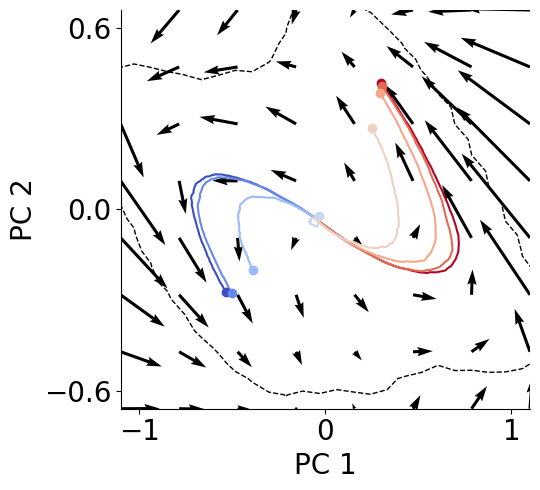

In [9]:
fig, ax = plt.subplots(figsize=(5.5, 5))
norm = colors.Normalize(vmin=-3.5, vmax=3.5)
cmap = rvb

# plot vector field
ax.quiver(
    flip_horizontally * x/xrange, 
    flip_vertically * y/xrange, 
    flip_horizontally * u/xrange, 
    flip_vertically * v/xrange, 
    angles='xy', 
    color='black', 
    scale_units='xy', 
    scale=10, 
    zorder=150
)

# plot trial-averaged trajectories
ax.plot(
    flip_horizontally * leftevidence[:time, 0]/xrange, 
    flip_vertically * leftevidence[:time, 1]/xrange, 
    '-', color=cmap(norm(-3.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wleftevidence[:time, 0]/xrange, 
    flip_vertically * wleftevidence[:time, 1]/xrange, 
    '-', color=cmap(norm(-2.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wwleftevidence[:time, 0]/xrange, 
    flip_vertically * wwleftevidence[:time, 1]/xrange, 
    '-', color=cmap(norm(-1.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wwwleftevidence[:time, 0]/xrange, 
    flip_vertically * wwwleftevidence[:time, 1]/xrange, 
    '-', color=cmap(norm(-0.5)), zorder=1100
)
ax.plot(
    flip_horizontally * rightevidence[:time, 0]/xrange, 
    flip_vertically * rightevidence[:time, 1]/xrange, 
    '-', color=cmap(norm(3.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wrightevidence[:time, 0]/xrange, 
    flip_vertically * wrightevidence[:time, 1]/xrange, 
    '-', color=cmap(norm(2.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wwrightevidence[:time, 0]/xrange, 
    flip_vertically * wwrightevidence[:time, 1]/xrange, 
    '-', color=cmap(norm(1.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wwwrightevidence[:time, 0]/xrange, 
    flip_vertically * wwwrightevidence[:time, 1]/xrange, 
    '-', color=cmap(norm(0.5)), zorder=1100
)

ax.plot(
    flip_horizontally * leftevidence[time-1:time, 0]/xrange, 
    flip_vertically * leftevidence[time-1:time, 1]/xrange, 
    'o', color=cmap(norm(-3.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wleftevidence[time-1:time, 0]/xrange, 
    flip_vertically * wleftevidence[time-1:time, 1]/xrange, 
    'o', color=cmap(norm(-2.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wwleftevidence[time-1:time, 0]/xrange, 
    flip_vertically * wwleftevidence[time-1:time, 1]/xrange, 
    'o', color=cmap(norm(-1.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wwwleftevidence[time-1:time, 0]/xrange, 
    flip_vertically * wwwleftevidence[time-1:time, 1]/xrange, 
    'o', color=cmap(norm(-0.5)), zorder=1100
)
ax.plot(
    flip_horizontally * rightevidence[time-1:time, 0]/xrange, 
    flip_vertically * rightevidence[time-1:time, 1]/xrange, 
    'o', color=cmap(norm(3.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wrightevidence[time-1:time, 0]/xrange, 
    flip_vertically * wrightevidence[time-1:time, 1]/xrange, 
    'o', color=cmap(norm(2.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wwrightevidence[time-1:time, 0]/xrange, 
    flip_vertically * wwrightevidence[time-1:time, 1]/xrange, 
    'o', color=cmap(norm(1.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wwwrightevidence[time-1:time, 0]/xrange, 
    flip_vertically * wwwrightevidence[time-1:time, 1]/xrange, 
    'o', color=cmap(norm(0.5)), zorder=1100
)

# plot sample zone
z_pc__ = np.reshape(z_pc_[:,:time,:], (-1, 2))
counts,xbins,ybins = np.histogram2d(
    flip_horizontally * z_pc__[:,0] / xrange, 
    flip_vertically * z_pc__[:,1] / xrange,
    bins=30
)
cs = ax.contour(
    counts.transpose(),
    extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
    linewidths=1, 
    linestyles = "dashed", 
    cmap = 'gray', 
    levels = [50,10000], 
    zorder=1000)

# axes labels
ax.set_ylabel("PC 2", fontsize=20)
ax.set_xlabel("PC 1", fontsize=20)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-0.6, 0, 0.6])
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-0.66, 0.66])
ax.tick_params(axis='both', which='major', labelsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

# Plot input dynamics

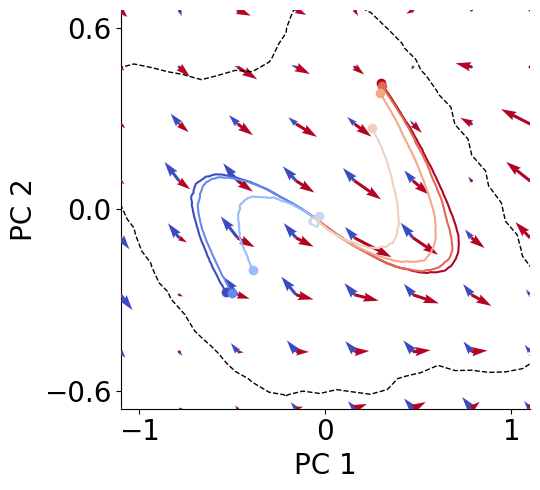

In [10]:
fig, ax = plt.subplots(figsize=(5.5, 5))
norm = colors.Normalize(vmin=-3.5, vmax=3.5)
cmap = rvb

# plot vector field
ax.quiver(
    flip_horizontally * x/xrange, 
    flip_vertically * y/xrange, 
    flip_horizontally * u_left/xrange * p_lc.T, 
    flip_vertically * v_left/xrange * p_lc.T, 
    angles='xy', 
    color=blue, 
    scale_units='xy', 
    scale=10, 
    zorder=150
)

ax.quiver(
    flip_horizontally * x/xrange, 
    flip_vertically * y/xrange, 
    flip_horizontally * u_right/xrange * p_rc.T, 
    flip_vertically * v_right/xrange * p_rc.T, 
    angles='xy', 
    color=red, 
    scale_units='xy', 
    scale=10, 
    zorder=150
)

# plot trial-averaged trajectories
ax.plot(
    flip_horizontally * leftevidence[:time, 0]/xrange, 
    flip_vertically * leftevidence[:time, 1]/xrange, 
    '-', color=cmap(norm(-3.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wleftevidence[:time, 0]/xrange, 
    flip_vertically * wleftevidence[:time, 1]/xrange, 
    '-', color=cmap(norm(-2.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wwleftevidence[:time, 0]/xrange, 
    flip_vertically * wwleftevidence[:time, 1]/xrange, 
    '-', color=cmap(norm(-1.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wwwleftevidence[:time, 0]/xrange, 
    flip_vertically * wwwleftevidence[:time, 1]/xrange, 
    '-', color=cmap(norm(-0.5)), zorder=1100
)
ax.plot(
    flip_horizontally * rightevidence[:time, 0]/xrange, 
    flip_vertically * rightevidence[:time, 1]/xrange, 
    '-', color=cmap(norm(3.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wrightevidence[:time, 0]/xrange, 
    flip_vertically * wrightevidence[:time, 1]/xrange, 
    '-', color=cmap(norm(2.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wwrightevidence[:time, 0]/xrange, 
    flip_vertically * wwrightevidence[:time, 1]/xrange, 
    '-', color=cmap(norm(1.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wwwrightevidence[:time, 0]/xrange, 
    flip_vertically * wwwrightevidence[:time, 1]/xrange, 
    '-', color=cmap(norm(0.5)), zorder=1100
)

ax.plot(
    flip_horizontally * leftevidence[time-1:time, 0]/xrange, 
    flip_vertically * leftevidence[time-1:time, 1]/xrange, 
    'o', color=cmap(norm(-3.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wleftevidence[time-1:time, 0]/xrange, 
    flip_vertically * wleftevidence[time-1:time, 1]/xrange, 
    'o', color=cmap(norm(-2.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wwleftevidence[time-1:time, 0]/xrange, 
    flip_vertically * wwleftevidence[time-1:time, 1]/xrange, 
    'o', color=cmap(norm(-1.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wwwleftevidence[time-1:time, 0]/xrange, 
    flip_vertically * wwwleftevidence[time-1:time, 1]/xrange, 
    'o', color=cmap(norm(-0.5)), zorder=1100
)
ax.plot(
    flip_horizontally * rightevidence[time-1:time, 0]/xrange, 
    flip_vertically * rightevidence[time-1:time, 1]/xrange, 
    'o', color=cmap(norm(3.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wrightevidence[time-1:time, 0]/xrange, 
    flip_vertically * wrightevidence[time-1:time, 1]/xrange, 
    'o', color=cmap(norm(2.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wwrightevidence[time-1:time, 0]/xrange, 
    flip_vertically * wwrightevidence[time-1:time, 1]/xrange, 
    'o', color=cmap(norm(1.5)), zorder=1100
)
ax.plot(
    flip_horizontally * wwwrightevidence[time-1:time, 0]/xrange, 
    flip_vertically * wwwrightevidence[time-1:time, 1]/xrange, 
    'o', color=cmap(norm(0.5)), zorder=1100
)

# plot sample zone
z_pc__ = np.reshape(z_pc_[:,:time,:], (-1, 2))
counts,xbins,ybins = np.histogram2d(
    flip_horizontally * z_pc__[:,0] / xrange, 
    flip_vertically * z_pc__[:,1] / xrange,
    bins=30
)
cs = ax.contour(
    counts.transpose(),
    extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
    linewidths=1, 
    linestyles = "dashed", 
    cmap = 'gray', 
    levels = [50,10000], 
    zorder=1000)

# axes labels
ax.set_ylabel("PC 2", fontsize=20)
ax.set_xlabel("PC 1", fontsize=20)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-0.6, 0, 0.6])
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-0.66, 0.66])
ax.tick_params(axis='both', which='major', labelsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()